<a href="https://colab.research.google.com/github/rakeshpuppala2590/Market-Anomaly-Detection-2/blob/main/Market_Anomaly_Detection_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LOGISTIC REGRESSION

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare the data
def prepare_data(df):
    # Drop the 'Data' column as it's the date
    X = df.drop(['Y', 'Data'], axis=1)
    y = df['Y']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, X.columns

def evaluate_models(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
    }

    results = {}
    feature_importance = {}

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

        results[name] = {
            'Classification Report': classification_report(y_test, y_pred),
            'ROC AUC': roc_auc,
            'Cross Val ROC AUC': cv_scores.mean(),
            'Cross Val Std': cv_scores.std()
        }

        # Get feature importance if available
        if hasattr(model, 'coef_'):
            feature_importance[name] = model.coef_[0]
        elif hasattr(model, 'feature_importances_'):
            feature_importance[name] = model.feature_importances_

    return results, feature_importance, X_train, X_test, y_train, y_test

# Load the data
df = pd.read_csv('Financial_Market_Data.csv')
X_scaled, y, feature_names = prepare_data(df)
results, feature_importance, X_train, X_test, y_train, y_test = evaluate_models(X_scaled, y)

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    print(f"ROC AUC Score: {metrics['ROC AUC']:.3f}")
    print(f"Cross-validated ROC AUC: {metrics['Cross Val ROC AUC']:.3f} (+/- {metrics['Cross Val Std']*2:.3f})")
    print("\nClassification Report:")
    print(metrics['Classification Report'])

# Plot feature importance for the best performing model
def plot_feature_importance(feature_importance, feature_names, model_name):
    plt.figure(figsize=(12, 6))
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(feature_importance)
    }).sort_values('Importance', ascending=True)

    plt.barh(range(len(importance)), importance['Importance'])
    plt.yticks(range(len(importance)), importance['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance - {model_name}')
    plt.tight_layout()
    return plt


Logistic Regression Results:
ROC AUC Score: 0.918
Cross-validated ROC AUC: 0.845 (+/- 0.163)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       177
           1       0.77      0.65      0.71        46

    accuracy                           0.89       223
   macro avg       0.84      0.80      0.82       223
weighted avg       0.88      0.89      0.88       223


Random Forest Results:
ROC AUC Score: 0.952
Cross-validated ROC AUC: 0.537 (+/- 0.298)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       177
           1       0.82      0.72      0.77        46

    accuracy                           0.91       223
   macro avg       0.88      0.84      0.86       223
weighted avg       0.91      0.91      0.91       223


Gradient Boosting Results:
ROC AUC Score: 0.936
Cross-validated ROC AUC: 0.846 (+/- 0.060)

Classification Report:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

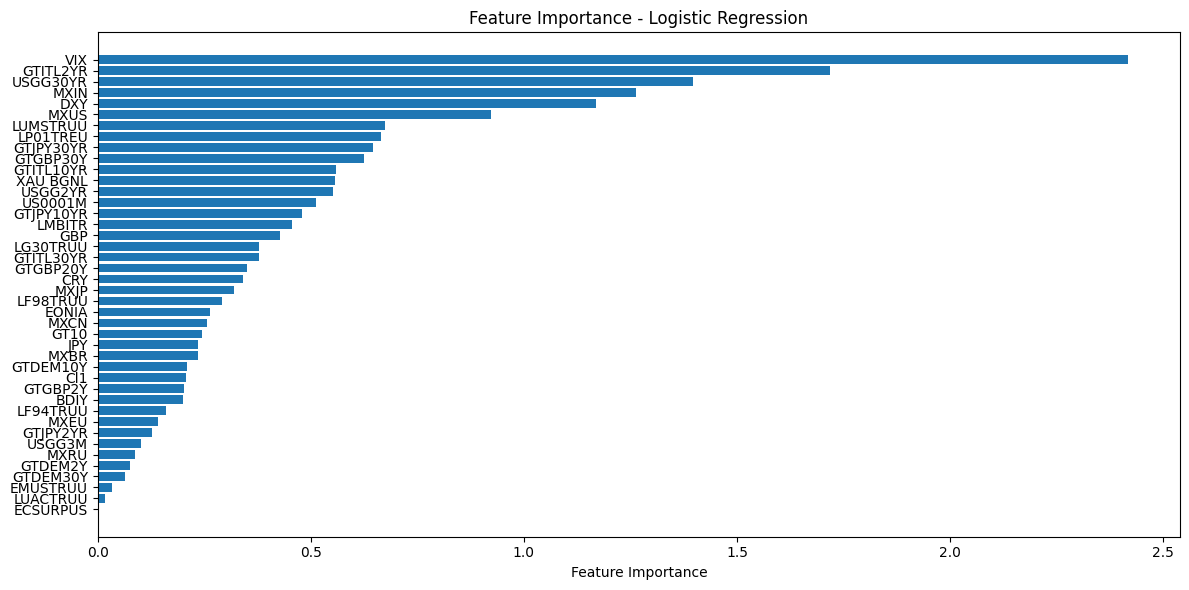

In [5]:
plot_feature_importance(feature_importance['Logistic Regression'], feature_names, 'Logistic Regression')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

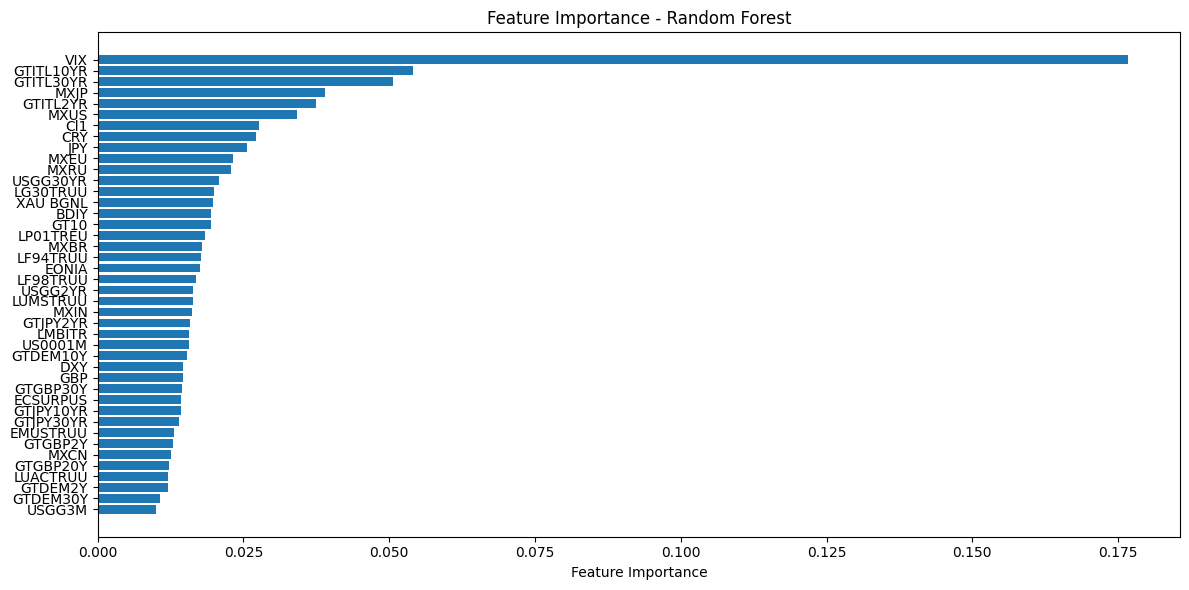

In [6]:
plot_feature_importance(feature_importance['Random Forest'], feature_names, 'Random Forest')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

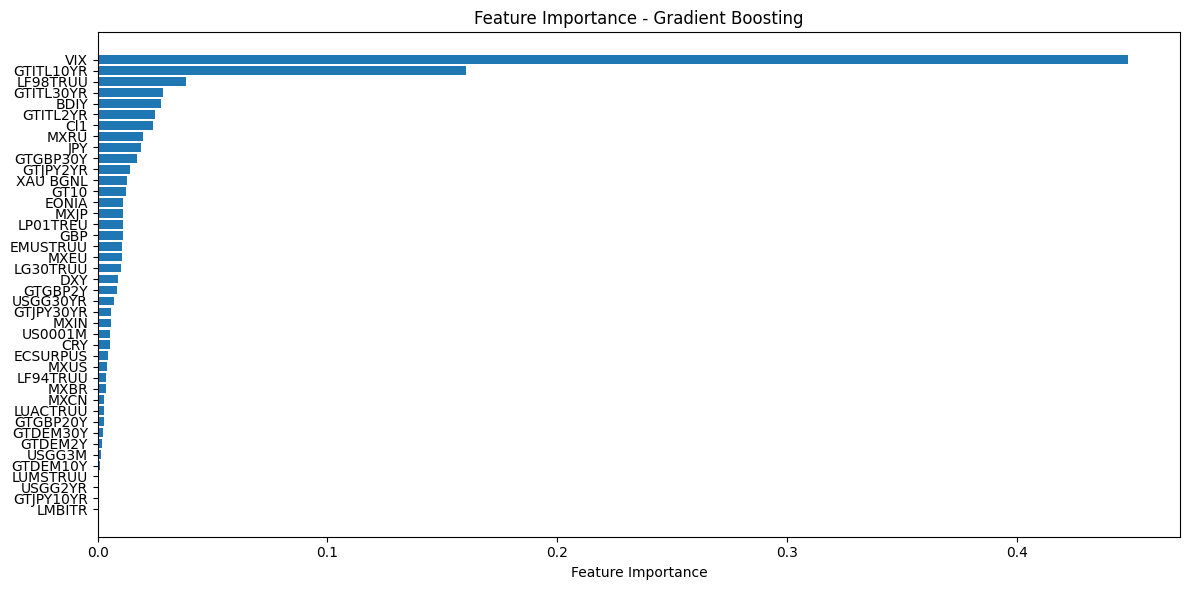

In [7]:
plot_feature_importance(feature_importance['Gradient Boosting'], feature_names, 'Gradient Boosting')

In [11]:
import plotly.graph_objects as go
import plotly.express as px

In [12]:
def plot_roc_curves(models, X_test, y_test):
    """
    Plot ROC curves for all models using plotly for interactive visualization
    """
    fig = go.Figure()
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)

        fig.add_trace(go.Scatter(x=fpr, y=tpr,
                                name=f'{name} (AUC = {auc_score:.3f})',
                                mode='lines'))

    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                            name='Random',
                            mode='lines',
                            line=dict(dash='dash')))

    fig.update_layout(title='ROC Curves Comparison',
                     xaxis_title='False Positive Rate',
                     yaxis_title='True Positive Rate',
                     height=600,
                     width=800)
    return fig

def plot_learning_curves(model, X, y, model_name):
    """
    Plot learning curves to analyze bias-variance tradeoff
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Cross-validation score')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

    plt.xlabel('Training Examples')
    plt.ylabel('ROC AUC Score')
    plt.title(f'Learning Curves - {model_name}')
    plt.legend(loc='best')
    plt.grid(True)
    return plt

def analyze_feature_correlations(X, feature_names):
    """
    Analyze and visualize feature correlations
    """
    corr_matrix = pd.DataFrame(X, columns=feature_names).corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    return plt

def perform_permutation_importance(model, X_test, y_test, feature_names):
    """
    Calculate permutation importance for more robust feature importance
    """
    r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': r.importances_mean,
        'Std': r.importances_std
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.errorbar(importance_df['Importance'], range(len(importance_df)),
                xerr=importance_df['Std'], fmt='o')
    plt.yticks(range(len(importance_df)), importance_df['Feature'])
    plt.xlabel('Permutation Importance')
    plt.title('Feature Permutation Importance')
    plt.tight_layout()
    return plt, importance_df

def plot_precision_recall_curves(models, X_test, y_test):
    """
    Plot precision-recall curves for all models
    """
    plt.figure(figsize=(10, 6))

    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    return plt

def analyze_predictions_over_time(model, X, dates, y_true):
    """
    Analyze model predictions over time
    """
    y_pred_proba = model.predict_proba(X)[:, 1]

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=dates, y=y_pred_proba,
                            name='Anomaly Probability',
                            mode='lines'))

    fig.add_trace(go.Scatter(x=dates[y_true == 1],
                            y=y_pred_proba[y_true == 1],
                            name='Actual Anomalies',
                            mode='markers',
                            marker=dict(size=10, color='red')))

    fig.update_layout(title='Anomaly Predictions Over Time',
                     xaxis_title='Date',
                     yaxis_title='Anomaly Probability',
                     height=500,
                     width=1000)
    return fig

In [ ]:
models = {
    'Logistic Regression': results['Logistic Regression'],
    'Random Forest': results['Random Forest'],
    'Gradient Boosting': results['Gradient Boosting'],
    'Neural Network': results['Neural Network']
}

roc_fig = plot_roc_curves(models, X_test, y_test)
roc_fig.show()

for name, model in models.items():
    learning_fig = plot_learning_curves(model, X_scaled, y, name)
    plt.show()

corr_fig = analyze_feature_correlations(X_scaled, feature_names)
plt.show()

best_model = models['Gradient Boosting']
perm_importance_fig, importance_df = perform_permutation_importance(
    best_model, X_test, y_test, feature_names
)
plt.show()
print("\nPermutation Importance Results:")
print(importance_df)

pr_fig = plot_precision_recall_curves(models, X_test, y_test)
plt.show()

dates = df['Data']
time_analysis_fig = analyze_predictions_over_time(
    best_model, X_scaled, dates, y
)
time_analysis_fig.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from transformers import pipeline
import torch
from datetime import datetime, timedelta
import yfinance as yf

class MarketAnomalyLLM:
    def __init__(self, model_name="facebook/bart-large"):
        """
        Initialize the Market Anomaly LLM system
        model_name: The HuggingFace model to use for text generation
        """
        self.scaler = StandardScaler()
        self.isolation_forest = IsolationForest(random_state=42, contamination=0.1)
        self.summarizer = pipeline("summarization", model=model_name)

    def prepare_features(self, df):
        """
        Create advanced technical indicators and market context features
        """
        features = pd.DataFrame()

        # Price-based features
        features['returns'] = df['Close'].pct_change()
        features['volatility'] = features['returns'].rolling(20).std()
        features['rsi'] = self.calculate_rsi(df['Close'])
        features['macd'] = self.calculate_macd(df['Close'])

        # Volume-based features
        features['volume_change'] = df['Volume'].pct_change()
        features['volume_ma_ratio'] = df['Volume'] / df['Volume'].rolling(20).mean()

        # Market context features
        features['price_level'] = df['Close'] / df['Close'].rolling(200).mean()
        features['trend_strength'] = self.calculate_trend_strength(df['Close'])

        return features.fillna(0)

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    def calculate_macd(self, prices):
        """Calculate MACD indicator"""
        exp1 = prices.ewm(span=12, adjust=False).mean()
        exp2 = prices.ewm(span=26, adjust=False).mean()
        return exp1 - exp2

    def calculate_trend_strength(self, prices):
        """Calculate trend strength using linear regression"""
        ma_short = prices.rolling(20).mean()
        ma_long = prices.rolling(50).mean()
        return (ma_short - ma_long) / ma_long

    def detect_anomalies(self, features):
        """
        Detect anomalies using Isolation Forest and generate severity scores
        """
        scaled_features = self.scaler.fit_transform(features)
        anomaly_scores = self.isolation_forest.fit_predict(scaled_features)
        anomaly_severity = self.isolation_forest.score_samples(scaled_features)

        return anomaly_scores, anomaly_severity

    def generate_market_context(self, symbol, date):
        """
        Fetch broader market context around the anomaly date
        """
        end_date = datetime.strptime(date, '%Y-%m-%d')
        start_date = end_date - timedelta(days=30)

        # Fetch market data
        market_data = yf.download('^GSPC', start=start_date, end=end_date)
        sector_data = yf.download(self.get_sector_etf(symbol), start=start_date, end=end_date)

        context = {
            'market_return': market_data['Close'].pct_change().mean() * 100,
            'market_volatility': market_data['Close'].pct_change().std() * 100,
            'sector_return': sector_data['Close'].pct_change().mean() * 100,
            'sector_volatility': sector_data['Close'].pct_change().std() * 100
        }

        return context

    def get_sector_etf(self, symbol):
        """Map stock to its sector ETF"""
        sector_mapping = {
            'XLF': ['JPM', 'BAC', 'WFC'],  # Financial sector
            'XLK': ['AAPL', 'MSFT', 'GOOGL'],  # Technology sector
            'XLE': ['XOM', 'CVX', 'COP'],  # Energy sector
            # Add more sectors as needed
        }

        for etf, symbols in sector_mapping.items():
            if symbol in symbols:
                return etf
        return '^GSPC'  # Default to S&P 500

    def generate_analysis_report(self, data, anomaly_date, anomaly_severity):
        """
        Generate a detailed analysis report using LLM
        """
        context = self.generate_market_context(data['symbol'], anomaly_date)

        report_template = f"""
        Market Anomaly Analysis for {data['symbol']} on {anomaly_date}:

        Anomaly Severity: {anomaly_severity:.2f}

        Price Action:
        - Daily Return: {data['returns']:.2%}
        - Volatility: {data['volatility']:.2%}
        - RSI: {data['rsi']:.2f}

        Volume Analysis:
        - Volume Change: {data['volume_change']:.2%}
        - Volume/MA Ratio: {data['volume_ma_ratio']:.2f}

        Market Context:
        - Market Return: {context['market_return']:.2%}
        - Sector Return: {context['sector_return']:.2%}
        - Market Volatility: {context['market_volatility']:.2%}
        """

        # Generate summary using LLM
        summary = self.summarizer(report_template, max_length=150, min_length=50)[0]['summary_text']

        return {
            'detailed_report': report_template,
            'summary': summary,
            'anomaly_severity': anomaly_severity,
            'market_context': context
        }

    def analyze_market_data(self, df, symbol):
        """
        Main function to analyze market data and detect anomalies
        """
        # Prepare features
        features = self.prepare_features(df)

        # Detect anomalies
        anomaly_scores, anomaly_severity = self.detect_anomalies(features)

        # Generate reports for significant anomalies
        reports = []
        for i, score in enumerate(anomaly_scores):
            if score == -1:  # Anomaly detected
                date = df.index[i].strftime('%Y-%m-%d')
                data = {
                    'symbol': symbol,
                    'returns': features['returns'].iloc[i],
                    'volatility': features['volatility'].iloc[i],
                    'rsi': features['rsi'].iloc[i],
                    'volume_change': features['volume_change'].iloc[i],
                    'volume_ma_ratio': features['volume_ma_ratio'].iloc[i]
                }

                report = self.generate_analysis_report(data, date, anomaly_severity[i])
                reports.append(report)

        return reports